In [1]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
np.random.seed(20200129)

In [2]:
def simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N):
    """
   generate similated data points

         X, y = simulations(pi, mu_1, mu_0, dim, sigma_1, sigma_0, N = 1000)

     Inputs:
             pi_1: prior probability for Y = 1
             mu_1, mu_0:   means for X|Y=1 and X|Y=0
             dim:   dimension of the feature space of X
             sigma_1, sigma_0: standard deviations for X|Y=1 and X|Y=0
             N: number of data points

     Outputs:
            X: data points with features
            y: classification results
    """ 
    # generate y from Bernolli(pi) as a vector with N entries
    y = np.random.binomial(1, pi_1, N)
    X = np.zeros([N, dim]) # initialize X
    num_1 = np.sum(y == 1)
    num_0 = np.sum(y == 0)
    X[y == 1] = np.random.multivariate_normal(mean = mu_1, cov = sigma_1, size = num_1)
    X[y == 0] = np.random.multivariate_normal(mean = mu_0, cov = sigma_0, size = num_0)
    return X, y

In [3]:
# import baseline models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE  
from imblearn.pipeline import Pipeline as Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import (GridSearchCV,StratifiedKFold)
# scale and split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [4]:
def Bayes_proba(x, pi_1, mu_0, mu_1, Sigma):
    tmp = np.exp((mu_0[:,None] - mu_1[:,None]).T @ np.linalg.solve(Sigma, (x.T - (mu_0[:,None] + mu_1[:,None])/2)))
    return (pi_1/(pi_1 + (1 - pi_1) * tmp))[0,:]

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score, precision_recall_curve, auc
from sklearn.metrics import roc_curve, accuracy_score
seed=7
models = [] # Here I will append all the algorithms that I will use. Each one will run in all the created datasets.
models.append(('LDA', LinearDiscriminantAnalysis()))

In [6]:
def simulation_results_vary_pi_1(pi_1s, mu, dim, N, N_test):
    """
   generate similated data points, then get socres and plots

         simulation_results(dim = 10, mu = 1)

     Inputs:
             pi_1s: list of prior probabilities for Y = 1
             mu:   means for X|Y=1 and X|Y=0 are (mu, 0, ...,0) and (-mu, 0, ...,0) respectively
             dim:   dimension of the feature space of X
             N: number of training data points
             N_test: number of test points

     Outputs:
            X: data points with features
            y: classification results
    """ 
    # initialization
    np.random.seed(20200129)
    mu_1 = np.zeros(dim,)
    mu_1[0] = mu
    mu_0 = np.zeros(dim,)
    mu_0[0] = -mu
    sigma_1 = np.identity(dim)
    sigma_0 = np.identity(dim)


    # compare different classifiers
    fpr_full = []
    tpr_full = []
    precision_full = []
    recall_full = []
    fpr_Bayes_full = []
    tpr_Bayes_full = []
    precision_Bayes_full = []
    recall_Bayes_full = []
    measures = ['AUROC','AUPRC','accuracy','log loss','F1']
    num_models = len(pi_1s) # number of model settings to compare
    roc_cut = np.zeros([num_models + 1,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve for LDA
    prc_cut = np.zeros([num_models + 1,]).astype(int) # cut points for precision, recall, thresholds for PRC curve for LDA
    roc_Bayes_cut = np.zeros([num_models + 1,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve of Bayes
    prc_Bayes_cut = np.zeros([num_models + 1,]).astype(int) # cut points for precision, recall, thresholds for PRC curve of Bayes
    i = 0 # looping index
    name = 'LDA'
    model = LinearDiscriminantAnalysis()
    for pi_1 in pi_1s:
            X_train, y_train = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N)
            X_test, y_test = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N_test)
            # class distribution
            train_ratio = y_train.sum()/len(y_train)
            test_ratio = y_test.sum()/len(y_test)
            print('Positive ratios for pi_1 =',pi_1, ', mu =', mu,', dim =',dim,' are',train_ratio,
                  'and',test_ratio,'for training and testing respectively.')
            y_pred_proba = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            fpr_full = np.concatenate((fpr_full, fpr))
            tpr_full = np.concatenate((tpr_full, tpr))
            roc_cut[i + 1] = roc_cut[i] + fpr.shape[0]
            #Area under ROC curve
            auroc = roc_auc_score(y_test,y_pred_proba)
            precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
            precision_full = np.concatenate((precision_full, precision))
            recall_full = np.concatenate((recall_full, recall))
            prc_cut[i + 1] = prc_cut[i] + recall.shape[0]
            # area under PRC curve
            auprc = auc(recall, precision)
            
            accuracy = accuracy_score(y_test, model.predict(X_test))
            average_precision = average_precision_score(y_test, model.predict(X_test))
            f1 = f1_score(y_test, model.predict(X_test))
            log_loss_score = log_loss(y_test, model.predict(X_test))
            recall = recall_score(y_test, model.predict(X_test))
            
            # Bayes
            y_pred_proba_Bayes = Bayes_proba(X_test, pi_1, mu_0, mu_1, Sigma = sigma_1)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_Bayes)
            fpr_Bayes_full = np.concatenate((fpr_Bayes_full, fpr))
            tpr_Bayes_full = np.concatenate((tpr_Bayes_full, tpr))
            roc_Bayes_cut[i + 1] = roc_Bayes_cut[i] + fpr.shape[0]
            #Area under ROC curve for Bayes
            Bayes_auroc = roc_auc_score(y_test,y_pred_proba_Bayes)
            precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba_Bayes)
            precision_Bayes_full = np.concatenate((precision_Bayes_full, precision))
            recall_Bayes_full = np.concatenate((recall_Bayes_full, recall))
            prc_Bayes_cut[i + 1] = prc_Bayes_cut[i] + recall.shape[0]
            # area under PRC curve for Bayes
            Bayes_auprc = auc(recall, precision)

            print(name,': AUROC = {:.3f}, AUPRC = {:.3f}, F1 score = {:.3f},'.format(auroc,auprc,f1),
                  '. \nAccuracy = {:.3f}, log loss = {:.3f},'.format(accuracy, log_loss_score),
                 'while Bayes classifier has AUROC = {:.3f}, AUPRC = {:.3f}.'.format(Bayes_auroc,Bayes_auprc))
            print ("--"*30)
            i = i + 1
    
    

    legends = []
    #plot ROC
    for i in range(num_models):
        pi_1 = pi_1s[i]
        legends.append('Bayes $\pi_1=$'+str(pi_1))
        legends.append('LDA $\pi_1=$'+str(pi_1))
        plt.plot(fpr_Bayes_full[roc_Bayes_cut[i]:roc_Bayes_cut[i + 1]],tpr_Bayes_full[roc_Bayes_cut[i]:roc_Bayes_cut[i + 1]], '--')
        plt.plot(fpr_full[roc_cut[i]:roc_cut[i + 1]],tpr_full[roc_cut[i]:roc_cut[i + 1]], label=name)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    title_name = 'ROC curve with $\pi_1\in$' + str(pi_1s) + ',$\mu$=' + str(mu) + ',N=' + str(N) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(legends,loc='lower center',shadow=False, ncol=2)
    save_name = 'change_pi_10mu' + str(int(10*mu)) + '_N' + str(N) + '_dim' + str(dim) + '_simulation_ROC_curve.png'
    plt.savefig(save_name)
    plt.show()

    # plot PRC
    for i in range(num_models):
        plt.plot(recall_Bayes_full[prc_Bayes_cut[i]:prc_Bayes_cut[i + 1]],precision_Bayes_full[prc_Bayes_cut[i]:prc_Bayes_cut[i + 1]], '--')
        plt.plot(recall_full[prc_cut[i]:prc_cut[i + 1]],precision_full[prc_cut[i]:prc_cut[i + 1]], label=name)
    plt.xlabel('recall')
    plt.ylabel('precision')
    title_name = 'PR curve with $\pi_1\in$' + str(pi_1s) + ',$\mu$=' + str(mu) + ',N=' + str(N) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(legends,loc='lower center',shadow=False, ncol=2)
    save_name = 'change_pi_10mu' + str(int(10*mu)) + '_N' + str(N) + '_dim' + str(dim) + '_simulation_PRcurve.png'
    plt.savefig(save_name)
    plt.show()
    
    print ("--"*30)
    print ("--"*30)

Positive ratios for pi_1 = 0.1 , mu = 1 , dim = 5  are 0.06 and 0.098 for training and testing respectively.
LDA : AUROC = 0.865, AUPRC = 0.438, F1 score = 0.355, . 
Accuracy = 0.909, log loss = 3.143, while Bayes classifier has AUROC = 0.916, AUPRC = 0.628.
------------------------------------------------------------
Positive ratios for pi_1 = 0.2 , mu = 1 , dim = 5  are 0.08 and 0.213 for training and testing respectively.
LDA : AUROC = 0.918, AUPRC = 0.795, F1 score = 0.607, . 
Accuracy = 0.872, log loss = 4.421, while Bayes classifier has AUROC = 0.931, AUPRC = 0.835.
------------------------------------------------------------
Positive ratios for pi_1 = 0.3 , mu = 1 , dim = 5  are 0.2 and 0.318 for training and testing respectively.
LDA : AUROC = 0.908, AUPRC = 0.853, F1 score = 0.692, . 
Accuracy = 0.839, log loss = 5.561, while Bayes classifier has AUROC = 0.924, AUPRC = 0.868.
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu = 1 ,

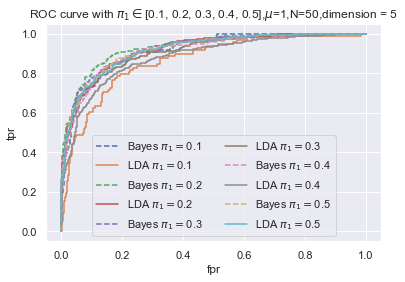

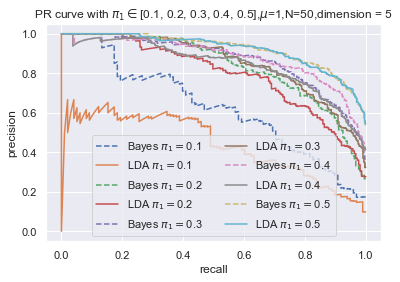

------------------------------------------------------------
------------------------------------------------------------


In [7]:
simulation_results_vary_pi_1(pi_1s = [0.1,0.2,0.3,0.4,0.5],mu = 1, dim = 5, N = 50, N_test = 1000)

Positive ratios for pi_1 = 0.1 , mu = 0.5 , dim = 5  are 0.06 and 0.098 for training and testing respectively.
LDA : AUROC = 0.655, AUPRC = 0.158, F1 score = 0.016, . 
Accuracy = 0.879, log loss = 4.179, while Bayes classifier has AUROC = 0.750, AUPRC = 0.276.
------------------------------------------------------------
Positive ratios for pi_1 = 0.2 , mu = 0.5 , dim = 5  are 0.08 and 0.213 for training and testing respectively.
LDA : AUROC = 0.701, AUPRC = 0.384, F1 score = 0.018, . 
Accuracy = 0.786, log loss = 7.391, while Bayes classifier has AUROC = 0.786, AUPRC = 0.544.
------------------------------------------------------------
Positive ratios for pi_1 = 0.3 , mu = 0.5 , dim = 5  are 0.2 and 0.318 for training and testing respectively.
LDA : AUROC = 0.738, AUPRC = 0.595, F1 score = 0.326, . 
Accuracy = 0.719, log loss = 9.705, while Bayes classifier has AUROC = 0.758, AUPRC = 0.607.
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu

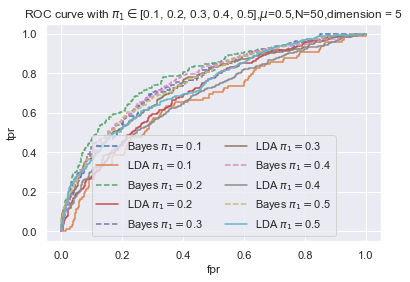

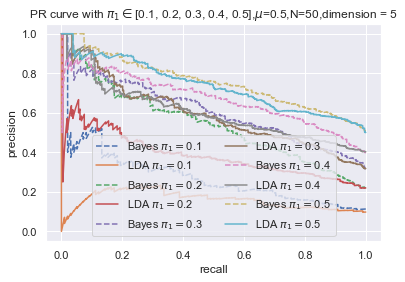

------------------------------------------------------------
------------------------------------------------------------


In [8]:
simulation_results_vary_pi_1(pi_1s = [0.1,0.2,0.3,0.4,0.5],mu = 0.5, dim = 5, N = 50, N_test = 1000)

In [9]:
def simulation_results_vary_N(pi_1, mu, dim, Ns, N_test):
    """
   generate similated data points, then get socres and plots

         simulation_results(dim = 10, mu = 1)

     Inputs:
             pi_1: list of prior probabilities for Y = 1
             mu:   means for X|Y=1 and X|Y=0 are (mu, 0, ...,0) and (-mu, 0, ...,0) respectively
             dim:   dimension of the feature space of X
             Ns: numbers of training data points
             N_test: number of test points

     Outputs:
            X: data points with features
            y: classification results
    """ 
    # initialization
    np.random.seed(20200129)
    mu_1 = np.zeros(dim,)
    mu_1[0] = mu
    mu_0 = np.zeros(dim,)
    mu_0[0] = -mu
    sigma_1 = np.identity(dim)
    sigma_0 = np.identity(dim)


    # compare different classifiers
    fpr_full = []
    tpr_full = []
    precision_full = []
    recall_full = []
    fpr_Bayes_full = []
    tpr_Bayes_full = []
    precision_Bayes_full = []
    recall_Bayes_full = []
    measures = ['AUROC','AUPRC','accuracy','log loss','F1']
    num_models = len(Ns) # number of model settings to compare
    roc_cut = np.zeros([num_models + 1,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve for LDA
    prc_cut = np.zeros([num_models + 1,]).astype(int) # cut points for precision, recall, thresholds for PRC curve for LDA
    roc_Bayes_cut = np.zeros([num_models + 1,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve of Bayes
    prc_Bayes_cut = np.zeros([num_models + 1,]).astype(int) # cut points for precision, recall, thresholds for PRC curve of Bayes
    i = 0 # looping index
    name = 'LDA'
    model = LinearDiscriminantAnalysis()
    for N in Ns:
            X_train, y_train = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N)
            X_test, y_test = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N_test)
            # class distribution
            train_ratio = y_train.sum()/len(y_train)
            test_ratio = y_test.sum()/len(y_test)
            print('Positive ratios for pi_1 =',pi_1, ', mu =', mu,', dim =',dim,' are',train_ratio,
                  'and',test_ratio,'for training and testing respectively.')
            y_pred_proba = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            fpr_full = np.concatenate((fpr_full, fpr))
            tpr_full = np.concatenate((tpr_full, tpr))
            roc_cut[i + 1] = roc_cut[i] + fpr.shape[0]
            #Area under ROC curve
            auroc = roc_auc_score(y_test,y_pred_proba)
            precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
            precision_full = np.concatenate((precision_full, precision))
            recall_full = np.concatenate((recall_full, recall))
            prc_cut[i + 1] = prc_cut[i] + recall.shape[0]
            # area under PRC curve
            auprc = auc(recall, precision)
            
            accuracy = accuracy_score(y_test, model.predict(X_test))
            average_precision = average_precision_score(y_test, model.predict(X_test))
            f1 = f1_score(y_test, model.predict(X_test))
            log_loss_score = log_loss(y_test, model.predict(X_test))
            recall = recall_score(y_test, model.predict(X_test))
            
            # Bayes
            y_pred_proba_Bayes = Bayes_proba(X_test, pi_1, mu_0, mu_1, Sigma = sigma_1)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_Bayes)
            fpr_Bayes_full = np.concatenate((fpr_Bayes_full, fpr))
            tpr_Bayes_full = np.concatenate((tpr_Bayes_full, tpr))
            roc_Bayes_cut[i + 1] = roc_Bayes_cut[i] + fpr.shape[0]
            #Area under ROC curve for Bayes
            Bayes_auroc = roc_auc_score(y_test,y_pred_proba_Bayes)
            precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba_Bayes)
            precision_Bayes_full = np.concatenate((precision_Bayes_full, precision))
            recall_Bayes_full = np.concatenate((recall_Bayes_full, recall))
            prc_Bayes_cut[i + 1] = prc_Bayes_cut[i] + recall.shape[0]
            # area under PRC curve for Bayes
            Bayes_auprc = auc(recall, precision)

            print(name,': AUROC = {:.3f}, AUPRC = {:.3f}, F1 score = {:.3f},'.format(auroc,auprc,f1),
                  '. \nAccuracy = {:.3f}, log loss = {:.3f},'.format(accuracy, log_loss_score),
                 'while Bayes classifier has AUROC = {:.3f}, AUPRC = {:.3f}.'.format(Bayes_auroc,Bayes_auprc))
            print ("--"*30)
            i = i + 1
    
    

    legends = []
    #plot ROC
    for i in range(num_models):
        N = Ns[i]
        legends.append('Bayes $N=$'+str(N))
        legends.append('LDA $N=$'+str(N))
        plt.plot(fpr_Bayes_full[roc_Bayes_cut[i]:roc_Bayes_cut[i + 1]],tpr_Bayes_full[roc_Bayes_cut[i]:roc_Bayes_cut[i + 1]], '--')
        plt.plot(fpr_full[roc_cut[i]:roc_cut[i + 1]],tpr_full[roc_cut[i]:roc_cut[i + 1]], label=name)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    title_name = 'ROC curve with $\pi_1=$' + str(pi_1) + ',$\mu$=' + str(mu) + ',N$\in$' + str(Ns) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(legends,loc='lower center',shadow=False, ncol=2)
    save_name = 'change_N_10mu' + str(int(10*mu)) + '_10pi' + str(int(10*pi_1)) + '_dim' + str(dim) + '_simulation_ROC_curve.png'
    plt.savefig(save_name)
    plt.show()

    # plot PRC
    for i in range(num_models):
        plt.plot(recall_Bayes_full[prc_Bayes_cut[i]:prc_Bayes_cut[i + 1]],precision_Bayes_full[prc_Bayes_cut[i]:prc_Bayes_cut[i + 1]], '--')
        plt.plot(recall_full[prc_cut[i]:prc_cut[i + 1]],precision_full[prc_cut[i]:prc_cut[i + 1]], label=name)
    plt.xlabel('recall')
    plt.ylabel('precision')
    title_name = 'PR curve with $\pi_1=$' + str(pi_1) + ',$\mu$=' + str(mu) + ',N$\in$' + str(Ns) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(legends,loc='lower center',shadow=False, ncol=2)
    save_name = 'change_N_10mu' + str(int(10*mu)) + '_10pi' + str(int(10*pi_1)) + '_dim' + str(dim) + '_simulation_PRcurve.png'
    plt.savefig(save_name)
    plt.show()
    
    print ("--"*30)
    print ("--"*30)

Positive ratios for pi_1 = 0.4 , mu = 0.5 , dim = 5  are 0.64 and 0.386 for training and testing respectively.
LDA : AUROC = 0.654, AUPRC = 0.533, F1 score = 0.581, . 
Accuracy = 0.501, log loss = 17.235, while Bayes classifier has AUROC = 0.766, AUPRC = 0.661.
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu = 0.5 , dim = 5  are 0.38 and 0.404 for training and testing respectively.
LDA : AUROC = 0.699, AUPRC = 0.611, F1 score = 0.591, . 
Accuracy = 0.645, log loss = 12.261, while Bayes classifier has AUROC = 0.786, AUPRC = 0.713.
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu = 0.5 , dim = 5  are 0.3333333333333333 and 0.409 for training and testing respectively.
LDA : AUROC = 0.607, AUPRC = 0.504, F1 score = 0.345, . 
Accuracy = 0.613, log loss = 13.367, while Bayes classifier has AUROC = 0.754, AUPRC = 0.681.
------------------------------------------------------------
Positive ratios f

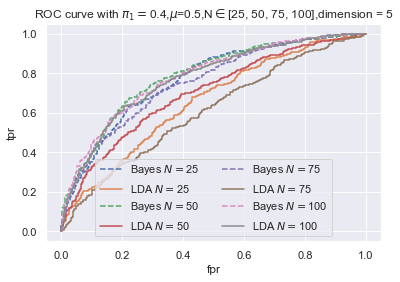

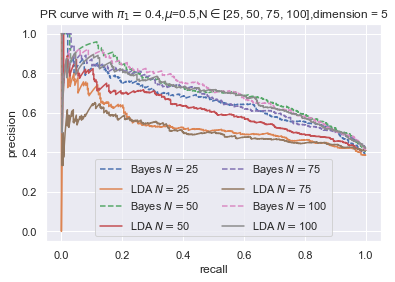

------------------------------------------------------------
------------------------------------------------------------


In [10]:
simulation_results_vary_N(pi_1 = 0.4, mu = 0.5, dim = 5, Ns = [25,50,75,100], N_test = 1000)

In [11]:
def simulation_results_vary_mu(pi_1, mus, dim, N, N_test):
    """
   generate similated data points, then get socres and plots

         simulation_results(dim = 10, mu = 1)

     Inputs:
             pi_1: list of prior probabilities for Y = 1
             mus:   means for X|Y=1 and X|Y=0 are (mu, 0, ...,0) and (-mu, 0, ...,0) respectively
             dim:   dimension of the feature space of X
             N: numbers of training data points
             N_test: number of test points

     Outputs:
            X: data points with features
            y: classification results
    """ 
    # initialization
    np.random.seed(20200129)

    # compare different classifiers
    fpr_full = []
    tpr_full = []
    precision_full = []
    recall_full = []
    fpr_Bayes_full = []
    tpr_Bayes_full = []
    precision_Bayes_full = []
    recall_Bayes_full = []
    measures = ['AUROC','AUPRC','accuracy','log loss','F1']
    num_models = len(mus) # number of model settings to compare
    roc_cut = np.zeros([num_models + 1,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve for LDA
    prc_cut = np.zeros([num_models + 1,]).astype(int) # cut points for precision, recall, thresholds for PRC curve for LDA
    roc_Bayes_cut = np.zeros([num_models + 1,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve of Bayes
    prc_Bayes_cut = np.zeros([num_models + 1,]).astype(int) # cut points for precision, recall, thresholds for PRC curve of Bayes
    i = 0 # looping index
    name = 'LDA'
    model = LinearDiscriminantAnalysis()
    for mu in mus:
        mu_1 = np.zeros(dim,)
        mu_1[0] = mu
        mu_0 = np.zeros(dim,)
        mu_0[0] = -mu
        sigma_1 = np.identity(dim)
        sigma_0 = np.identity(dim)
        X_train, y_train = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N)
        X_test, y_test = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N_test)
        # class distribution
        train_ratio = y_train.sum()/len(y_train)
        test_ratio = y_test.sum()/len(y_test)
        print('Positive ratios for pi_1 =',pi_1, ', mu =', mu,', dim =',dim,' are',train_ratio,
              'and',test_ratio,'for training and testing respectively.')
        y_pred_proba = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        fpr_full = np.concatenate((fpr_full, fpr))
        tpr_full = np.concatenate((tpr_full, tpr))
        roc_cut[i + 1] = roc_cut[i] + fpr.shape[0]
        #Area under ROC curve
        auroc = roc_auc_score(y_test,y_pred_proba)
        precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
        precision_full = np.concatenate((precision_full, precision))
        recall_full = np.concatenate((recall_full, recall))
        prc_cut[i + 1] = prc_cut[i] + recall.shape[0]
        # area under PRC curve
        auprc = auc(recall, precision)

        accuracy = accuracy_score(y_test, model.predict(X_test))
        average_precision = average_precision_score(y_test, model.predict(X_test))
        f1 = f1_score(y_test, model.predict(X_test))
        log_loss_score = log_loss(y_test, model.predict(X_test))
        recall = recall_score(y_test, model.predict(X_test))

        # Bayes
        y_pred_proba_Bayes = Bayes_proba(X_test, pi_1, mu_0, mu_1, Sigma = sigma_1)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_Bayes)
        fpr_Bayes_full = np.concatenate((fpr_Bayes_full, fpr))
        tpr_Bayes_full = np.concatenate((tpr_Bayes_full, tpr))
        roc_Bayes_cut[i + 1] = roc_Bayes_cut[i] + fpr.shape[0]
        #Area under ROC curve for Bayes
        Bayes_auroc = roc_auc_score(y_test,y_pred_proba_Bayes)
        precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba_Bayes)
        precision_Bayes_full = np.concatenate((precision_Bayes_full, precision))
        recall_Bayes_full = np.concatenate((recall_Bayes_full, recall))
        prc_Bayes_cut[i + 1] = prc_Bayes_cut[i] + recall.shape[0]
        # area under PRC curve for Bayes
        Bayes_auprc = auc(recall, precision)

        print(name,': AUROC = {:.3f}, AUPRC = {:.3f}, F1 score = {:.3f},'.format(auroc,auprc,f1),
              '. \nAccuracy = {:.3f}, log loss = {:.3f},'.format(accuracy, log_loss_score),
             'while Bayes classifier has AUROC = {:.3f}, AUPRC = {:.3f}.'.format(Bayes_auroc,Bayes_auprc))
        print ("--"*30)
        i = i + 1
    
    

    legends = []
    #plot ROC
    for i in range(num_models):
        mu = mus[i]
        legends.append('Bayes $\mu=$'+str(mu))
        legends.append('LDA $\mu=$'+str(mu))
        plt.plot(fpr_Bayes_full[roc_Bayes_cut[i]:roc_Bayes_cut[i + 1]],tpr_Bayes_full[roc_Bayes_cut[i]:roc_Bayes_cut[i + 1]], '--')
        plt.plot(fpr_full[roc_cut[i]:roc_cut[i + 1]],tpr_full[roc_cut[i]:roc_cut[i + 1]], label=name)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    title_name = 'ROC curve with $\pi_1=$' + str(pi_1) + ',$\mu\in$' + str(mus) + ',N=' + str(N) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(legends,loc='lower center',shadow=False, ncol=2)
    save_name = 'change_mu_N' + str(N) + '_10pi' + str(int(10*pi_1)) + '_dim' + str(dim) + '_simulation_ROC_curve.png'
    plt.savefig(save_name)
    plt.show()

    # plot PRC
    for i in range(num_models):
        plt.plot(recall_Bayes_full[prc_Bayes_cut[i]:prc_Bayes_cut[i + 1]],precision_Bayes_full[prc_Bayes_cut[i]:prc_Bayes_cut[i + 1]], '--')
        plt.plot(recall_full[prc_cut[i]:prc_cut[i + 1]],precision_full[prc_cut[i]:prc_cut[i + 1]], label=name)
    plt.xlabel('recall')
    plt.ylabel('precision')
    title_name = 'PR curve with $\pi_1=$' + str(pi_1) + ',$\mu\in$' + str(mus) + ',N=' + str(N) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(legends,loc='lower center',shadow=False, ncol=2)
    save_name = 'change_mu_N' + str(N) + '_10pi' + str(int(10*pi_1)) + '_dim' + str(dim) + '_simulation_PRcurve.png'
    plt.savefig(save_name)
    plt.show()
    
    print ("--"*30)
    print ("--"*30)

Positive ratios for pi_1 = 0.4 , mu = 0.25 , dim = 5  are 0.46 and 0.393 for training and testing respectively.
LDA : AUROC = 0.627, AUPRC = 0.505, F1 score = 0.516, . 
Accuracy = 0.623, log loss = 13.021, while Bayes classifier has AUROC = 0.658, AUPRC = 0.545.
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu = 0.5 , dim = 5  are 0.28 and 0.401 for training and testing respectively.
LDA : AUROC = 0.781, AUPRC = 0.726, F1 score = 0.622, . 
Accuracy = 0.723, log loss = 9.567, while Bayes classifier has AUROC = 0.785, AUPRC = 0.735.
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu = 0.75 , dim = 5  are 0.28 and 0.426 for training and testing respectively.
LDA : AUROC = 0.845, AUPRC = 0.806, F1 score = 0.645, . 
Accuracy = 0.755, log loss = 8.462, while Bayes classifier has AUROC = 0.854, AUPRC = 0.815.
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 

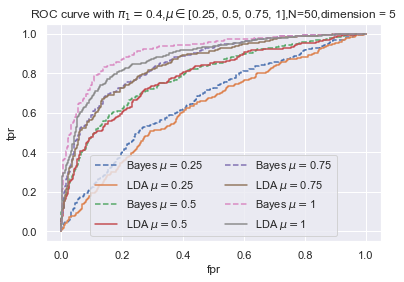

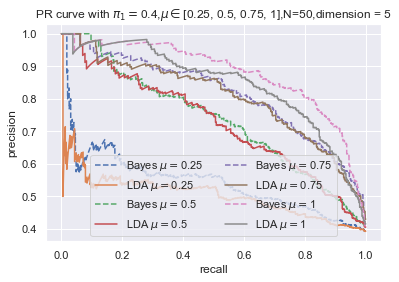

------------------------------------------------------------
------------------------------------------------------------


In [12]:
simulation_results_vary_mu(pi_1 = 0.4, mus = [0.25, 0.5, 0.75, 1], dim = 5, N = 50, N_test = 1000)

In [13]:
def simulation_results_basic(pi_1, mu, dim, N, N_test):
    """
   generate similated data points, then get socres and plots

         simulation_results(dim = 10, mu = 1)

     Inputs:
             pi_1: list of prior probability for Y = 1
             mu:   means for X|Y=1 and X|Y=0 are (mu, 0, ...,0) and (-mu, 0, ...,0) respectively
             dim:   dimension of the feature space of X
             N: number of training data points
             N_test: number of test points

     Outputs:
            X: data points with features
            y: classification results
    """ 
    # initialization
    np.random.seed(20200129)
    mu_1 = np.zeros(dim,)
    mu_1[0] = mu
    mu_0 = np.zeros(dim,)
    mu_0[0] = -mu
    sigma_1 = np.identity(dim)
    sigma_0 = np.identity(dim)


    # compare different classifiers
    fpr_full = []
    tpr_full = []
    precision_full = []
    recall_full = []
    fpr_Bayes_full = []
    tpr_Bayes_full = []
    precision_Bayes_full = []
    recall_Bayes_full = []
    measures = ['AUROC','AUPRC','accuracy','log loss','F1']
    num_models = 1 # number of model settings to compare
    roc_cut = np.zeros([num_models + 1,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve for LDA
    prc_cut = np.zeros([num_models + 1,]).astype(int) # cut points for precision, recall, thresholds for PRC curve for LDA
    roc_Bayes_cut = np.zeros([num_models + 1,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve of Bayes
    prc_Bayes_cut = np.zeros([num_models + 1,]).astype(int) # cut points for precision, recall, thresholds for PRC curve of Bayes
    i = 0 # looping index
    name = 'LDA'
    model = LinearDiscriminantAnalysis()
    X_train, y_train = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N)
    X_test, y_test = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N_test)
    # class distribution
    train_ratio = y_train.sum()/len(y_train)
    test_ratio = y_test.sum()/len(y_test)
    print('Positive ratios for pi_1 =',pi_1, ', mu =', mu,', dim =',dim,' are',train_ratio,
          'and',test_ratio,'for training and testing respectively.')
    y_pred_proba = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    fpr_full = np.concatenate((fpr_full, fpr))
    tpr_full = np.concatenate((tpr_full, tpr))
    roc_cut[i + 1] = roc_cut[i] + fpr.shape[0]
    #Area under ROC curve
    auroc = roc_auc_score(y_test,y_pred_proba)
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
    precision_full = np.concatenate((precision_full, precision))
    recall_full = np.concatenate((recall_full, recall))
    prc_cut[i + 1] = prc_cut[i] + recall.shape[0]
    # area under PRC curve
    auprc = auc(recall, precision)

    accuracy = accuracy_score(y_test, model.predict(X_test))
    average_precision = average_precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    log_loss_score = log_loss(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))

    # Bayes
    y_pred_proba_Bayes = Bayes_proba(X_test, pi_1, mu_0, mu_1, Sigma = sigma_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_Bayes)
    fpr_Bayes_full = np.concatenate((fpr_Bayes_full, fpr))
    tpr_Bayes_full = np.concatenate((tpr_Bayes_full, tpr))
    roc_Bayes_cut[i + 1] = roc_Bayes_cut[i] + fpr.shape[0]
    #Area under ROC curve for Bayes
    Bayes_auroc = roc_auc_score(y_test,y_pred_proba_Bayes)
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba_Bayes)
    precision_Bayes_full = np.concatenate((precision_Bayes_full, precision))
    recall_Bayes_full = np.concatenate((recall_Bayes_full, recall))
    prc_Bayes_cut[i + 1] = prc_Bayes_cut[i] + recall.shape[0]
    # area under PRC curve for Bayes
    Bayes_auprc = auc(recall, precision)

    print(name,': AUROC = {:.3f}, AUPRC = {:.3f}, F1 score = {:.3f},'.format(auroc,auprc,f1),
          '. \nAccuracy = {:.3f}, log loss = {:.3f},'.format(accuracy, log_loss_score),
         'while Bayes classifier has AUROC = {:.3f}, AUPRC = {:.3f}.'.format(Bayes_auroc,Bayes_auprc))
    print ("--"*30)
    
    

    legends = []
    #plot ROC
    for i in range(num_models):
        legends.append('Bayes')
        legends.append('LDA')
        plt.plot(fpr_Bayes_full[roc_Bayes_cut[i]:roc_Bayes_cut[i + 1]],tpr_Bayes_full[roc_Bayes_cut[i]:roc_Bayes_cut[i + 1]], '--')
        plt.plot(fpr_full[roc_cut[i]:roc_cut[i + 1]],tpr_full[roc_cut[i]:roc_cut[i + 1]], label=name)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    title_name = 'ROC curve with $\pi_1=$' + str(pi_1) + ',$\mu$=' + str(mu) + ',N=' + str(N) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(legends,loc='lower center',shadow=False, ncol=2)
    save_name = 'basic_10pi' + str(int(10*pi_1)) + '_10mu' + str(int(10*mu)) + '_N' + str(N) + '_dim' + str(dim) + '_simulation_ROC_curve.png'
    plt.savefig(save_name)
    plt.show()

    # plot PRC
    for i in range(num_models):
        plt.plot(recall_Bayes_full[prc_Bayes_cut[i]:prc_Bayes_cut[i + 1]],precision_Bayes_full[prc_Bayes_cut[i]:prc_Bayes_cut[i + 1]], '--')
        plt.plot(recall_full[prc_cut[i]:prc_cut[i + 1]],precision_full[prc_cut[i]:prc_cut[i + 1]], label=name)
    plt.xlabel('recall')
    plt.ylabel('precision')
    title_name = 'PR curve with $\pi_1=$' + str(pi_1) + ',$\mu$=' + str(mu) + ',N=' + str(N) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(legends,loc='lower center',shadow=False, ncol=2)
    save_name = 'basic_10pi' + str(int(10*pi_1)) + '_10mu' + str(int(10*mu)) + '_N' + str(N) + '_dim' + str(dim) + '_simulation_PRcurve.png'
    plt.savefig(save_name)
    plt.show()
    
    print ("--"*30)
    print ("--"*30)

Positive ratios for pi_1 = 0.4 , mu = 0.5 , dim = 5  are 0.46 and 0.393 for training and testing respectively.
LDA : AUROC = 0.751, AUPRC = 0.654, F1 score = 0.616, . 
Accuracy = 0.700, log loss = 10.362, while Bayes classifier has AUROC = 0.776, AUPRC = 0.689.
------------------------------------------------------------


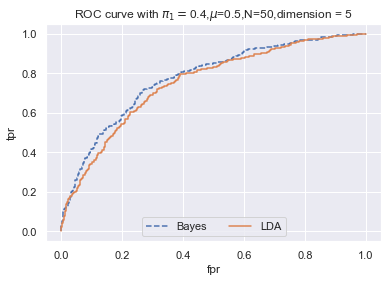

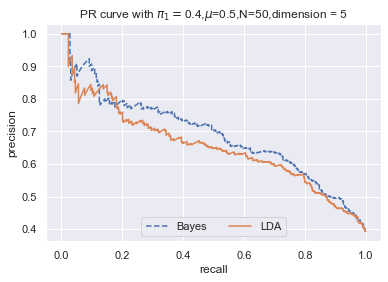

------------------------------------------------------------
------------------------------------------------------------


In [14]:
simulation_results_basic(pi_1 = 0.4, mu = 0.5, dim = 5, N = 50, N_test = 1000)